In [2]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    KFold, GridSearchCV, cross_validate, train_test_split
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [3]:
# 1.  Locate & load the two files
data_dir = Path(r"D:\University\Aalto\Project_course\CleanedData\features")
filenames = ["all_patient_features.csv", "all_patient_features_db2.csv"]
dfs = [pd.read_csv(data_dir / f) for f in filenames]

#Which columns are "metadata"?
meta_cols = ["patient_id", "Age", "Height", "Weight", "Gender", "fs"]


def split_meta_beatwise(df, meta_cols):
    """Return (meta_df, beatwise_df) and PRESERVE patient_id in beatwise_df."""
    meta_df = df.loc[:, [c for c in meta_cols if c in df.columns]]

    beatwise_cols = [
        c for c in df.columns
        if (
            c not in meta_cols                      # not metadata
        )
    ]

    # Ensure patient_id is present for merging later
    beatwise_df = df.loc[:, ["patient_id"] + beatwise_cols]

    return meta_df, beatwise_df

#Apply split to every file and concatenate
meta_parts, beat_parts = zip(
    *(split_meta_beatwise(df, meta_cols) for df in dfs)
)

meta_df      = pd.concat(meta_parts,  ignore_index=True)
beatwise_df  = pd.concat(beat_parts, ignore_index=True)


In [4]:
# Merge metadata and beatwise features on patient_id
df = meta_df.merge(beatwise_df, on="patient_id", how="inner")

# Define prefixes of the BCG-related features to keep
bcg_prefixes   = ("RI_", "RJ_", "RK_", "IJ_", "AI_", "AJ_", "AK_")
# Metadata to retain alongside BCG
meta_features  = ["Height", "Weight", "Gender", "fs"]  # keep these
#Target variable
target         = "Age"

# Any columns that should never enter the "pure‑BCG" model
non_bcg_prefixes = (
    "RR_", "HR_", "RR_SDNN", "RR_RMSSD", "RR_SDSD", "RR_CV",
    "patton", "PTT_", "fs"
)

# Filtering logic: select only useful BCG features and metadata
def keep(col: str) -> bool:
    # drop target and ID
    if col in (target, "patient_id"):
        return False
    if col.endswith(("_count", "_iqr")):
        return False
    if any(col.startswith(p) for p in non_bcg_prefixes):
        return False
    #Keep meta features you want 
    if col in meta_features:
        return True
    #keep the real BCG waveform stats 
    if col.startswith(bcg_prefixes):
        return True
    return False

# Select filtered features for input (X) and target (y)
feature_cols = [c for c in df.columns if keep(c)]
X = df[feature_cols].copy()
y = df[target].copy()

# Drop rows with insufficient valid BCG measurements (less than 5 non-NaNs)
# Even though this isnt needed because we have a cleaned data set
# I kept it just incase we receive a larger data set in the future that might have a high
# number or NaNs 
bcg_feature_columns = [c for c in X.columns if c.startswith(bcg_prefixes)]
min_bcg_non_nan = 5
mask = X[bcg_feature_columns].notna().sum(axis=1) >= min_bcg_non_nan
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)


In [ ]:
# Set up preprocessing pipeline: impute missing values and scale numeric features
numeric_cols = [c for c in X.columns if c != "Gender"]
categorical_cols = ["Gender"] if "Gender" in X.columns else []

preprocess = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler",  StandardScaler())
        ]), numeric_cols),
        ("cat", OneHotEncoder(drop="if_binary"), categorical_cols)
    ],
    remainder="drop",
)


rf_base = RandomForestRegressor(
    random_state=42,
    bootstrap=True,      # explicit; required for oob_score
    oob_score=True,
    n_jobs=-1
)

pipe_inner = Pipeline([
    ("prep", preprocess),
    ("reg",  rf_base)
])

param_grid = {
    "reg__n_estimators":      [200, 400, 600, 800],          # merged
    "reg__max_depth":         [None, 10, 20, 30],            # friend’s deeper range
    "reg__min_samples_split": [2, 4, 6, 8],                  # both ideas
    "reg__min_samples_leaf":  [1, 2, 4],
    "reg__max_features":      ["sqrt", "log2", 0.6, 0.8],
    "reg__bootstrap":         [True],                        # keep OOB
}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_inner,
    param_grid=param_grid,
    cv=inner_cv,
    scoring="neg_mean_absolute_error",
    refit=True,
    n_jobs=-1,
    verbose=0
)

cv_results = cross_validate(
    estimator=grid,
    X=X, y=y,
    cv=outer_cv,
    scoring={"MAE": make_scorer(mean_absolute_error)},
    return_estimator=True,
    n_jobs=-1,
    verbose=0
)

print(f"\nOuter-CV MAE  : {-cv_results['test_MAE'].mean():.2f} "
      f"± {cv_results['test_MAE'].std():.2f}")

best_idx    = np.argmin(cv_results["test_MAE"])
best_params = cv_results["estimator"][best_idx].best_params_
print("\nBest hyper-parameters:")
for k, v in best_params.items():
    print(f"  {k} = {v}")

# ── 5  Re-fit final pipeline on *all* data ───────────────────────────────────
best_rf_params = {k.replace("reg__", ""): v for k, v in best_params.items()}

preprocess_final = preprocess.fit(X)
X_all_proc       = preprocess_final.transform(X)

rf_final = RandomForestRegressor(
    **best_rf_params,
    random_state=42,
    n_jobs=-1,
    oob_score=True      # keep for quick sanity MAE
)
rf_final.fit(X_all_proc, y)
oob_mae = mean_absolute_error(y, rf_final.oob_prediction_)
print(f"OOB MAE       : {oob_mae:.2f}")

final_model = make_pipeline(preprocess_final, rf_final)
joblib.dump(final_model, "final_bcg_age_model_rf_best.pkl")
print("\n✓ Saved model → final_bcg_age_model_rf_best.pkl")



✓ Feature importances → final_bcg_feature_importance_rf_best.csv


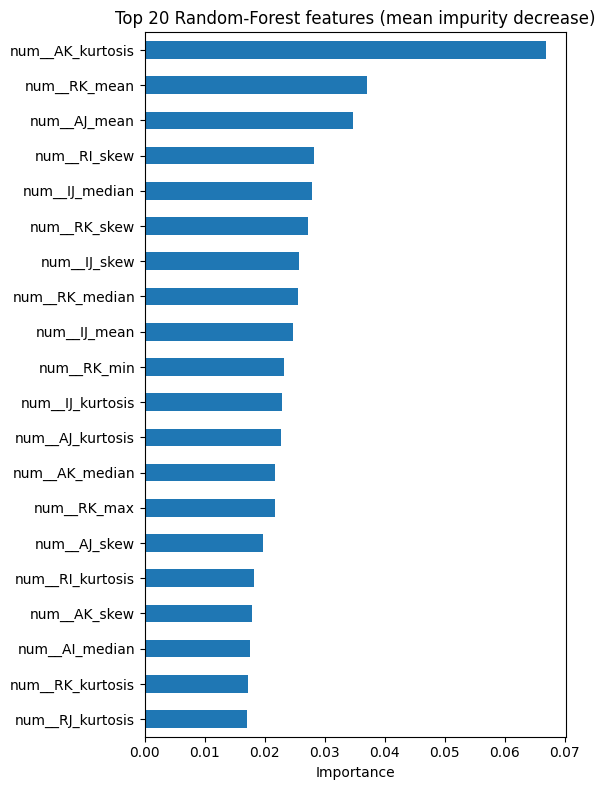

In [ ]:
# ── 6  Feature importances ───────────────────────────────────────────────────
feature_names = preprocess_final.get_feature_names_out()
importances   = rf_final.feature_importances_
imp_series    = pd.Series(importances, index=feature_names).sort_values(ascending=False)
imp_series.to_csv("final_bcg_feature_importance_rf_best.csv")
print("✓ Feature importances → final_bcg_feature_importance_rf_best.csv")

# optional quick plot
TOP_K = 20
imp_series.head(TOP_K).iloc[::-1].plot.barh(figsize=(6, 8))
plt.title(f"Top {TOP_K} Random-Forest features (mean impurity decrease)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Graphs


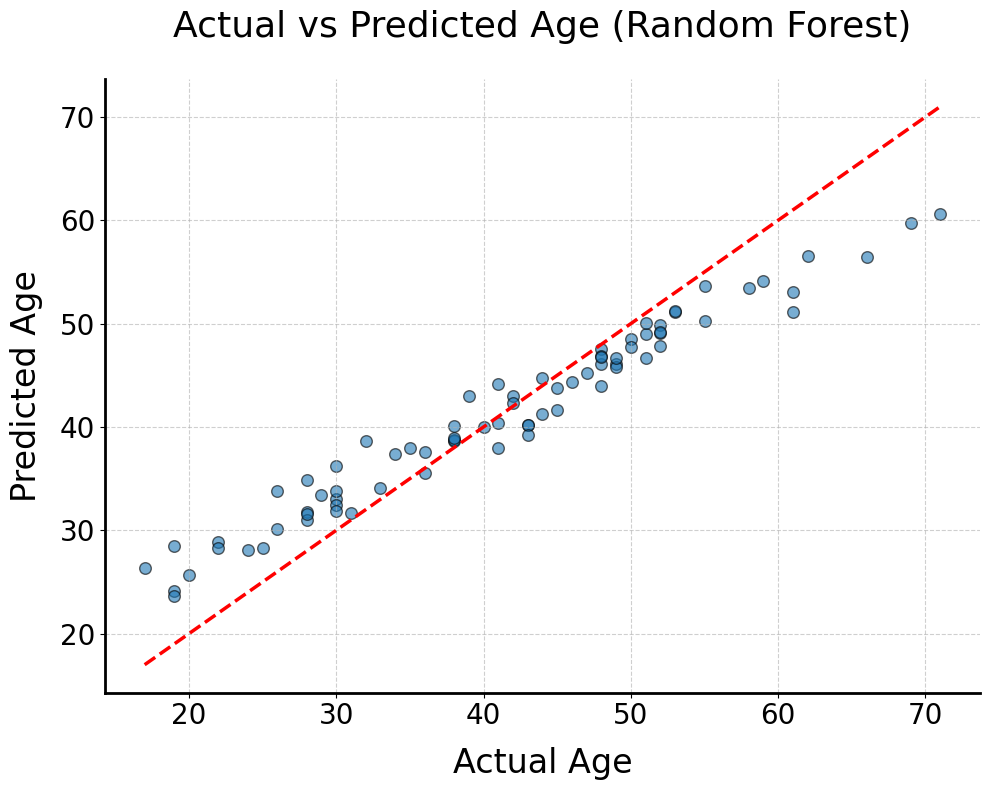

MAE  : 3.54
RMSE : 4.36
R²   : 0.88


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load pipeline
import joblib
pipeline = joblib.load("final_bcg_age_model_rf_best.pkl")

# Separate components
preprocess = pipeline.named_steps["columntransformer"]
model = pipeline.named_steps["randomforestregressor"]

# Predict on full dataset
X_proc = preprocess.transform(X)
y_pred = model.predict(X_proc)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.6, edgecolor='k', s=70)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2.5)
plt.xlabel("Actual Age", fontsize=24, labelpad=12)
plt.ylabel("Predicted Age", fontsize=24, labelpad=12)
plt.title("Actual vs Predicted Age (Random Forest)", fontsize=26, pad=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("rf_actual_vs_predicted.pdf", format="pdf")   # or .svg
plt.show()

# Print metrics
mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")
